In [1]:
import pandas as pd

# Load datasets
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

# Inspect the data
print(customers.head())
print(products.head())
print(transactions.head())

# Merge datasets based on customer and product ID
data = pd.merge(transactions, customers, on="CustomerID", how="left")
data = pd.merge(data, products, on="ProductID", how="left")

# Inspect merged data
print(data.head())


  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

In [2]:
# Feature Engineering: Total value per customer and product categories purchased
customer_features = data.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    num_transactions=("TransactionID", "count"),
    avg_transaction_value=("TotalValue", "mean")
).reset_index()

# Creating a matrix of customers and their purchased product categories
product_dummies = pd.get_dummies(data['Category'])
category_matrix = data[['CustomerID']].join(product_dummies).groupby('CustomerID').sum()

# Merging all customer features into one DataFrame
final_features = pd.merge(customer_features, category_matrix, on="CustomerID")

# Inspect the features
print(final_features.head())


  CustomerID  total_spent  num_transactions  avg_transaction_value  Books  \
0      C0001      3354.52                 5                670.904      1   
1      C0002      1862.74                 4                465.685      0   
2      C0003      2725.38                 4                681.345      0   
3      C0004      5354.88                 8                669.360      3   
4      C0005      2034.24                 3                678.080      0   

   Clothing  Electronics  Home Decor  
0         0            3           1  
1         2            0           2  
2         1            1           2  
3         0            2           3  
4         0            2           1  


In [3]:
from sklearn.preprocessing import StandardScaler

# Standardize features (important for similarity measures)
scaler = StandardScaler()
final_features_scaled = scaler.fit_transform(final_features.drop("CustomerID", axis=1))

# Inspect the scaled features
print(final_features_scaled[:5])


[[-0.06170143 -0.01145819 -0.07026341 -0.3211125  -1.04160638  1.55087763
  -0.22104388]
 [-0.87774353 -0.46749414 -0.93493297 -1.22113205  0.77663634 -1.14846331
   0.67666495]
 [-0.40585722 -0.46749414 -0.02627131 -1.22113205 -0.13248502 -0.248683
   0.67666495]
 [ 1.03254704  1.35664965 -0.0767689   1.47892659 -1.04160638  0.65109731
   1.57437379]
 [-0.78392861 -0.92353008 -0.04002806 -1.22113205 -1.04160638  0.65109731
  -0.22104388]]


In [4]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate Cosine Similarity between customers
similarity_matrix = cosine_similarity(final_features_scaled)

# Inspect the similarity matrix (first 5 rows)
print(similarity_matrix[:5, :5])


[[ 1.         -0.48569266  0.00913579  0.20797639  0.63954577]
 [-0.48569266  1.          0.73430244 -0.52172042  0.1850993 ]
 [ 0.00913579  0.73430244  1.         -0.38782443  0.62659662]
 [ 0.20797639 -0.52172042 -0.38782443  1.         -0.42206475]
 [ 0.63954577  0.1850993   0.62659662 -0.42206475  1.        ]]


In [5]:
# Get top 3 similar customers for each customer (C0001 - C0020)
top_3_similar_customers = {}
for idx, customer_id in enumerate(final_features["CustomerID"][:20]):  # First 20 customers
    similarity_scores = similarity_matrix[idx]
    similar_customers_idx = similarity_scores.argsort()[-4:-1][::-1]  # Exclude self and get top 3
    similar_customers = final_features["CustomerID"].iloc[similar_customers_idx]
    scores = similarity_scores[similar_customers_idx]
    top_3_similar_customers[customer_id] = list(zip(similar_customers, scores))

# Inspect the top 3 similar customers
print(top_3_similar_customers)


{'C0001': [('C0069', 0.9407645268782763), ('C0127', 0.8464136435133535), ('C0035', 0.8205467534857194)], 'C0002': [('C0103', 0.9042642927981942), ('C0062', 0.8996194316523932), ('C0134', 0.896498006139127)], 'C0003': [('C0166', 0.9735807428089185), ('C0031', 0.8917953346052679), ('C0159', 0.886971557634215)], 'C0004': [('C0122', 0.9053011527825046), ('C0113', 0.901179694499692), ('C0017', 0.9006619650504022)], 'C0005': [('C0197', 0.9973329264482712), ('C0007', 0.9264804915927919), ('C0095', 0.8951298736839268)], 'C0006': [('C0185', 0.8815380939803661), ('C0196', 0.8498678445546697), ('C0187', 0.8353063887191494)], 'C0007': [('C0005', 0.9264804915927919), ('C0140', 0.8970725844443916), ('C0197', 0.8965415446708989)], 'C0008': [('C0162', 0.9279532679550069), ('C0154', 0.8981159146878839), ('C0113', 0.8820876051797876)], 'C0009': [('C0029', 0.940268675423513), ('C0033', 0.9150971843133356), ('C0083', 0.9120460466920219)], 'C0010': [('C0030', 0.9171429718111553), ('C0029', 0.90756401922616

In [6]:
# Save the results in a CSV file
lookalike_df = pd.DataFrame({
    "CustomerID": list(top_3_similar_customers.keys()),
    "Lookalike_Customers": [', '.join([f"{cust} ({score:.2f})" for cust, score in similar]) for similar in top_3_similar_customers.values()]
})

lookalike_df.to_csv("Lookalike.csv", index=False)

# Inspect the saved results
print(lookalike_df.head())


  CustomerID                       Lookalike_Customers
0      C0001  C0069 (0.94), C0127 (0.85), C0035 (0.82)
1      C0002  C0103 (0.90), C0062 (0.90), C0134 (0.90)
2      C0003  C0166 (0.97), C0031 (0.89), C0159 (0.89)
3      C0004  C0122 (0.91), C0113 (0.90), C0017 (0.90)
4      C0005  C0197 (1.00), C0007 (0.93), C0095 (0.90)


In [8]:
# Calculate customer retention by comparing first-time and repeat buyers
first_time_buyers = transactions.groupby('CustomerID')['TransactionID'].count() == 1
repeat_buyers = transactions.groupby('CustomerID')['TransactionID'].count() > 1

retention_rate = repeat_buyers.sum() / len(first_time_buyers)
print(f"Customer Retention Rate: {retention_rate:.2%}")


Customer Retention Rate: 93.97%


In [9]:
# Calculate Customer Lifetime Value (CLV)
clv = transactions.groupby('CustomerID')['TotalValue'].sum()
clv = clv.sort_values(ascending=False)
print("Top 10 customers by Lifetime Value:\n", clv.head(10))


Top 10 customers by Lifetime Value:
 CustomerID
C0141    10673.87
C0054     8040.39
C0065     7663.70
C0156     7634.45
C0082     7572.91
C0188     7111.32
C0059     7073.28
C0028     6819.57
C0099     6715.72
C0165     6708.10
Name: TotalValue, dtype: float64


In [11]:
!pip install mlxtend

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
insurance 0.0.1 requires python-dotenv==0.21.0, but you have python-dotenv 1.0.1 which is incompatible.
insurance 0.0.1 requires scikit-learn==1.2.0, but you have scikit-learn 1.6.1 which is incompatible.

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.4 MB ? eta -:--:--
   --------------- ------------------------ 0.5/1.4 MB 1.1 MB/s eta 0:00:01
   --------------- ------------------------ 0.5/1.4 MB 1.1 MB/s eta 0:00:01
   ----------------------- ---------------- 0.8/1.4 MB 985.5 kB/s eta 0:00:01
   -------------------------------------- - 1.3/1.4 MB 1.2 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.1 MB 1.8 MB/s eta 0:00:06
   --- ------------------------------------ 1.0/11.1 MB 1.9 MB/s eta 0:00:06
   ----- ---------------------------------- 1.6/11.1 MB 2.2 MB/s eta 0:00:05
   ------- ----------------------------

In [17]:
!pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt


# Fit ARIMA model
model = ARIMA(monthly_sales, order=(5, 1, 0))  # p, d, q parameters
model_fit = model.fit()

# Make predictions
forecast = model_fit.forecast(steps=12)
print(f"Forecasted Sales for the next 12 months: {forecast}")

# Plot the results
plt.title('Monthly Sales Forecast')
plt.legend()
plt.show()


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


NameError: name 'monthly_sales' is not defined

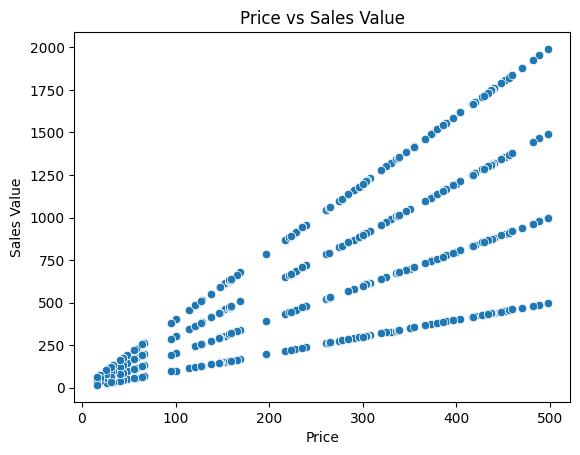

In [20]:
import seaborn as sns

# Scatter plot to show relationship between price and sales
sns.scatterplot(x='Price', y='TotalValue', data=transactions)
plt.title("Price vs Sales Value")
plt.xlabel("Price")
plt.ylabel("Sales Value")
plt.show()
